offer management using bank information - XGBOOST
---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration and Transformation](#Exploration) 
1. [Training Xgboost model using SageMaker](#Training)
1. [Hosting the model](#Hosting)
1. [Evaluating the model on test samples](#Evaluation)


---

## Background


---

## Setup

Let's start by specifying:

* The SageMaker role arn used to give learning and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto call with a the appropriate full SageMaker role arn string.
* The S3 bucket that you want to use for training and storing model objects.



In [24]:
import os
import boto3
import time
import re
import sagemaker 
role = sagemaker.get_execution_role()

# Now let's define the S3 bucket we'll used for the remainder of this example.

sess = sagemaker.Session()
bucket=sess.default_bucket() #  enter your s3 bucket where you will copy data and model artificats
prefix = 'sagemaker/LinearLearner-xgboost'  # place to upload training files within the bucket
print(f'output data will be stored in: {bucket}')

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210328T184539 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


output data will be stored in: sagemaker-us-east-1-858748618587


In [2]:
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Requirement already up-to-date: sagemaker in /opt/conda/lib/python3.7/site-packages (2.38.0)


In [25]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import sklearn as sk                              # For access to a variety of machine learning models
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from sklearn.datasets import dump_svmlight_file   # For outputting data to libsvm format for xgboost
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting output
import io                                         # For working with stream data
import sagemaker.amazon.common as smac            # For protobuf data format

Now lets read this into a Pandas data frame and take a look.

In [26]:
data = pd.read_csv('./bank_sample.csv')

#df1.columns = ['number_times_pregnant', 'plasma_glucose', 'diastolic_blood_pressure', 'triceps_skin_fold', 'serum_insulin', 'body_mass_index', 'pedigree_function', 'age', 'will_get_diabetes'] 
data.head()


,accept,age,job,marital,education,default,Balance,housing,loan,contact,Duration,Sessiontime,campaign,pdays,previous,poutcome
0,0,32,services,single,secondary,no,318,1,1,cellular,205,46,1,-1,0,unknown
1,0,60,retired,married,secondary,no,5032,1,1,cellular,304,279,3,266,1,failure
2,0,53,blue-collar,married,primary,no,2276,1,0,cellular,121,375,2,-1,0,unknown
3,1,46,technician,married,secondary,no,1880,0,0,cellular,122,1227,2,-1,0,unknown
4,0,36,services,married,secondary,no,494,1,0,unknown,193,247,1,-1,0,unknown


---
## Exploration
### Data exploration and transformations

In what follows we will do a basic exploration of the dataset to understand the size of data, various fields it has, the values different features take, distribution of target values etc.

In [27]:
# set display options
pd.set_option('display.max_columns', 100)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 6)         # Keep the output on one page


display(data)


# display positive and negative counts
display(data.iloc[:,8].value_counts())



,accept,age,job,marital,education,default,Balance,housing,loan,contact,Duration,Sessiontime,campaign,pdays,previous,poutcome
0,0,32,services,single,secondary,no,318,1,1,cellular,205,46,1,-1,0,unknown
1,0,60,retired,married,secondary,no,5032,1,1,cellular,304,279,3,266,1,failure
2,0,53,blue-collar,married,primary,no,2276,1,0,cellular,121,375,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,30,management,single,tertiary,no,8182,0,0,cellular,15,96,2,-1,0,unknown
2997,1,25,student,single,unknown,no,2006,0,0,cellular,115,361,1,-1,0,unknown
2998,0,39,blue-collar,married,primary,no,40,1,0,unknown,212,109,1,-1,0,unknown


0    2519
1     480
Name: loan, dtype: int64

col_0,% observations
job,
admin.,0.121374
blue-collar,0.227076
entrepreneur,0.030677
...,...
technician,0.159720
unemployed,0.031344
unknown,0.003001


col_0,% observations
marital,
divorced,0.120040
married,0.599533
single,0.280427


col_0,% observations
education,
primary,0.157052
secondary,0.511504
tertiary,0.293098
unknown,0.038346


col_0,% observations
default,
no,0.984328
yes,0.015672


col_0,% observations
contact,
cellular,0.646215
telephone,0.068690
unknown,0.285095


col_0,% observations
poutcome,
failure,0.109703
other,0.041014
success,0.030010
unknown,0.819273


,accept,age,Balance,housing,loan,Duration,Sessiontime,campaign,pdays,previous,no_previous_contact,not_working
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.0,2999.000000
mean,0.107703,41.091697,2656.066022,0.561187,0.160053,169.276092,253.510170,2.752584,41.250417,0.554852,0.0,0.103034
std,0.310056,10.719695,5762.799090,0.496325,0.366717,74.088037,250.577067,3.086609,103.102055,1.733661,0.0,0.304054
...,...,...,...,...,...,...,...,...,...,...,...,...
50%,0.000000,39.000000,834.000000,1.000000,0.000000,184.000000,183.000000,2.000000,-1.000000,0.000000,0.0,0.000000
75%,0.000000,49.000000,2770.000000,1.000000,0.000000,210.000000,313.500000,3.000000,-1.000000,0.000000,0.0,0.000000
max,1.000000,90.000000,90496.000000,1.000000,1.000000,327.000000,3881.000000,39.000000,774.000000,23.000000,0.0,1.000000


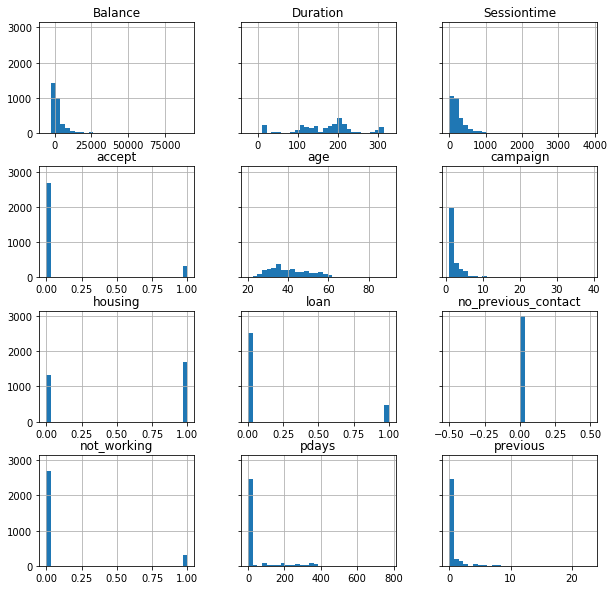

In [54]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

dataset = data.values
# split data into X and y
X = dataset[:,0:9]
X = X.astype(str)
Y = dataset[:,9]
# encode string input values as integers
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: : ", encoded_x.shape)
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

X shape: :  (2999, 1862)


,accept,age,Balance,housing,loan,Duration,Sessiontime,campaign,pdays,previous,no_previous_contact,not_working
accept,1.000000,0.029643,0.057489,-0.145794,-0.040182,-0.008657,0.384436,-0.080541,0.112315,0.132659,NaN,0.098077
age,0.029643,1.000000,0.121610,-0.195184,-0.007214,-0.057507,0.005182,0.011926,0.005230,0.012374,NaN,0.276993
Balance,0.057489,0.121610,1.000000,-0.066611,-0.087969,-0.061263,0.060959,-0.018159,-0.010584,0.013180,NaN,0.054028
...,...,...,...,...,...,...,...,...,...,...,...,...
previous,0.132659,0.012374,0.013180,0.029533,0.010321,0.032432,0.020866,-0.051569,0.583738,1.000000,NaN,0.016801
no_previous_contact,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
not_working,0.098077,0.276993,0.054028,-0.182144,-0.052221,0.011204,0.012330,-0.056706,-0.001866,0.016801,NaN,1.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


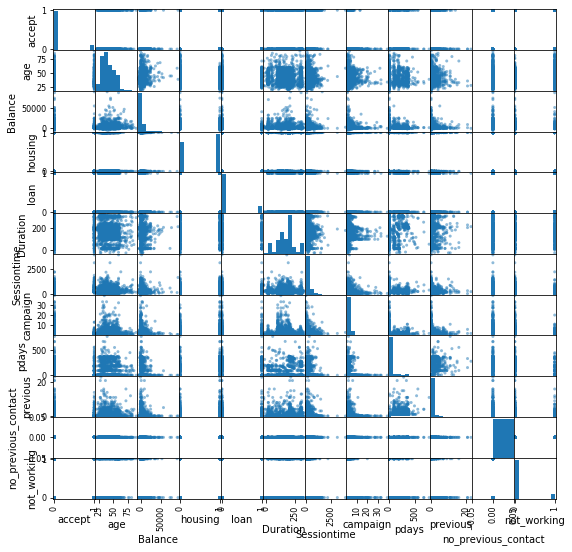

In [55]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(9, 9))
plt.show()

In [5]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder
# Fill missing values with 0
 
# Create a boolean mask for categorical columns
categorical_mask = (data.dtypes == object)
 
# Get list of categorical column names
categorical_columns = data.columns[categorical_mask].tolist()
 
# Print the head of the categorical columns
print(data[categorical_columns].head())
 
# Create LabelEncoder object: le
le = LabelEncoder()
 
# Apply LabelEncoder to categorical columns
data[categorical_columns] = data[categorical_columns].apply(lambda x: le.fit_transform(x))
 
# Print the head of the LabelEncoded categorical columns
print(data[categorical_columns].head())


           job  marital  education default   contact poutcome
0     services   single  secondary      no  cellular  unknown
1      retired  married  secondary      no  cellular  failure
2  blue-collar  married    primary      no  cellular  unknown
3   technician  married  secondary      no  cellular  unknown
4     services  married  secondary      no   unknown  unknown
   job  marital  education  default  contact  poutcome
0    7        2          1        0        0         3
1    5        1          1        0        0         0
2    1        1          0        0        0         3
3    9        1          1        0        0         3
4    7        1          1        0        2         3


In [ ]:

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

array_hot_encoded = ohe.fit_transform(data[categorical_columns])

#Convert it to df
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=data.index)

#Extract only the columns that didnt need to be encoded
data_other_cols = data.drop(columns=categorical_columns)
data_out = pd.concat([data_hot_encoded, data_other_cols], axis=1)
data=data_out
data_out

In [28]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_data = pd.get_dummies(data) 

In [30]:
## Combine the two datasets to convert the categorical values to binary indicators
#data_combined = pd.concat([data, data_test])

## convert the categorical variables to binary indicators
#data_combined_bin = pd.get_dummies(data_combined, prefix=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                                                         # 'race', 'sex', 'native-country', 'IncomeGroup'], drop_first=True)

# combine the income >50k indicators
#Income_50k = ((data_combined_bin.iloc[:,101]==1) | (data_combined_bin.iloc[:,102] ==1))+0;

# make the income indicator as first column
#data_combined_bin = pd.concat([Income_50k, data_combined_bin.iloc[:, 0:100]], axis=1)

# Post conversion to binary split the data sets separately
data_bin = model_data.iloc[0:model_data.shape[0], :]
#data_test_bin = data.iloc[data.shape[0]:, :]

# display the data sets post conversion to binary indicators
display(data_bin)
#display(data_test_bin)

# count number of positives and negatives
display(data_bin.iloc[:,0].value_counts())
#display(data_test_bin.iloc[:,0].value_counts())


,accept,age,Balance,housing,loan,Duration,Sessiontime,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,32,318,1,1,205,46,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
1,0,60,5032,1,1,304,279,3,266,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0
2,0,53,2276,1,0,121,375,2,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,30,8182,0,0,15,96,2,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1
2997,1,25,2006,0,0,115,361,1,-1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1
2998,0,39,40,1,0,212,109,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1


0    2676
1     323
Name: accept, dtype: int64

---

## Training

As our first training algorithm we pick `xgboost` algorithm.  `xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using `SageMaker's` managed, distributed training framework.

First we'll need to specify training parameters.  This includes:
1. The role to use
1. Our training job name
1. The `xgboost` algorithm container
1. Training instance type and count
1. S3 location for training data
1. S3 location for output data
1. Algorithm hyperparameters
1. Stopping conditions

Supported Training Input Format: csv, libsvm.
For csv input, right now we assume the input is separated by delimiter(automatically detect the separator by Python’s builtin sniffer tool), without a header line and also label is in the first column.
Scoring Output Format: csv.

* Since our data is in CSV format, we will convert our dataset to the way SageMaker's XGboost supports.
* We will keep the target field in first column and remaining features in the next few columns
* We will remove the header line
* We will also split the data into a separate training and validation sets
* Store the data into our s3 bucket



Split the data into 80% training and 20% validation and save it before calling XGboost

In [33]:
rand_split = np.random.rand(len(model_data))
train_list = rand_split < 0.1
val_list = (rand_split >= 0.1) & (rand_split < 0.2)
test_list = (rand_split >= 0.2) & (rand_split < 0.3)

data_train = model_data[train_list]
data_val = model_data[val_list]
data_test = model_data[test_list]

In [34]:
# Split the data randomly as 80% for training and remaining 20% and save them locally
#train_list = np.random.rand(len(data_bin)) < 0.8
#data_train = data_bin[train_list]
#data_val = data_bin[~train_list]
data_train.to_csv("train.csv", sep=',', header=False, index=False) # save training data 
data_val.to_csv("validate.csv", sep=',', header=False, index=False) # save validation data
data_test.to_csv("test.csv", sep=',', header=False,  index=False) # save test data


#### Upload training and validation data sets in the s3 bucket and prefix provided

In [35]:

train_file = 'train.csv'
val_file = 'validate.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/', train_file)).upload_file(train_file)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'val/', val_file)).upload_file(val_file)


#### Specify images used for training and hosting SageMaker's Xgboost algorithm

In [36]:
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='1')

In [37]:
import boto3
from time import gmtime, strftime

job_name = 'DEMO-xgboost-pima-indians' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/single-xgboost/".format(bucket, prefix),
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m5.large",
        "VolumeSizeInGB": 20
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.1",
        "gamma":"1",
        "min_child_weight":"1",
        "silent":"0",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "num_round": "20"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri":  "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/val/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}



Training job DEMO-xgboost-pima-indians2021-04-26-03-17-34


Now let's kick off our training job in SageMaker's distributed, managed training, using the parameters we just created. Because training is managed, we don't have to wait for our job to finish to continue, but for this case, let's setup a while loop so we can monitor the status of our training.

In [38]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**create_training_params)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')  

InProgress
CPU times: user 191 ms, sys: 28.1 ms, total: 219 ms
Wall time: 4min


We can read the training and evluation metrics from AWS cloudwatch.
train-auc: 0.916177 and 
validation-auc:0.906567.





---

## Hosting 
Now that we've trained the `xgboost` algorithm on our data, let's setup a model which can later be hosted.  We will:
1. Point to the scoring container
1. Point to the model.tar.gz that came from training
1. Create the hosting model

In [39]:
model_name=job_name + '-mdl'
xgboost_hosting_container = {
    'Image': container,
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=job_name)['ModelArtifacts']['S3ModelArtifacts'],
    'Environment': {'this': 'is'}
}

create_model_response = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=xgboost_hosting_container)

In [40]:
print(create_model_response['ModelArn'])
print(sm.describe_training_job(TrainingJobName=job_name)['ModelArtifacts']['S3ModelArtifacts'])

arn:aws:sagemaker:us-east-1:858748618587:model/demo-xgboost-pima-indians2021-04-26-03-17-34-mdl
s3://sagemaker-us-east-1-858748618587/sagemaker/LinearLearner-xgboost/single-xgboost/DEMO-xgboost-pima-indians2021-04-26-03-17-34/output/model.tar.gz


In [41]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m5.large',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2021-04-26-03-22-06
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:858748618587:endpoint-config/demo-xgboostendpointconfig-2021-04-26-03-22-06


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [42]:
%%time
import time

endpoint_name = 'XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

XGBoostEndpoint-2021-04-26-03-22-11
arn:aws:sagemaker:us-east-1:858748618587:endpoint/xgboostendpoint-2021-04-26-03-22-11
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:858748618587:endpoint/xgboostendpoint-2021-04-26-03-22-11
Status: InService
CPU times: user 100 ms, sys: 6.27 ms, total: 106 ms
Wall time: 7min 1s


---
## Evaluation
There are many ways to compare the performance of a machine learning model. In this example, we will generate predictions and compare the ranking metric AUC (Area Under the ROC Curve).

In [43]:
runtime= boto3.client('runtime.sagemaker')


In [47]:
# Simple function to create a csv from our numpy array

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()



In [48]:
# Function to generate prediction through sample data
def do_predict(data, endpoint_name, content_type):
    
    payload = np2csv(data)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    return preds

# Function to iterate through a larger data set and generate batch predictions
def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            datav = data.iloc[offset:(offset+batch_size),:].values
            results = do_predict(datav, endpoint_name, content_type)
            arrs.extend(results)
        else:
            datav = data.iloc[offset:items,:].values
            arrs.extend(do_predict(datav, endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [49]:
### read the saved data for scoring
data_train = pd.read_csv("train.csv", sep=',', header=None) 
data_test = pd.read_csv("test.csv", sep=',', header=None) 
data_val = pd.read_csv("validate.csv", sep=',', header=None) 

### Predict

In [50]:

preds_train_xgb = batch_predict(data_train.iloc[:, 1:], 1000, endpoint_name, 'text/csv')
preds_val_xgb = batch_predict(data_val.iloc[:, 1:], 1000, endpoint_name, 'text/csv')
preds_test_xgb = batch_predict(data_test.iloc[:, 1:], 1000, endpoint_name, 'text/csv')

...

#AUC ROC

In [51]:
from sklearn.metrics import roc_auc_score
train_labels = data_train.iloc[:,0];
val_labels = data_val.iloc[:,0];
test_labels = data_test.iloc[:,0];

print("Training AUC", roc_auc_score(train_labels, preds_train_xgb)) 
print("Validation AUC", roc_auc_score(val_labels, preds_val_xgb) )
print("Test AUC", roc_auc_score(test_labels, preds_test_xgb) )


Training AUC 0.9715998155832181
Validation AUC 0.8604662797678607
Test AUC 0.8507354714251265


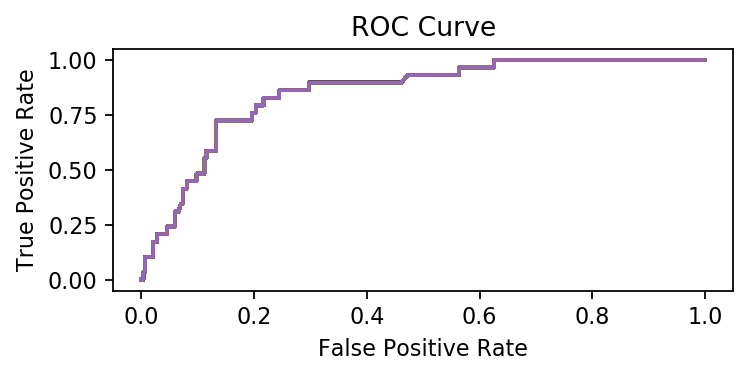

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, average_precision_score
import matplotlib.pyplot as plt

labels = test_labels[0:].apply(lambda row: True if row==1 else False)
fpr_tpr = []
for prediction in preds_test_xgb:
    fpr, tpr, _ = roc_curve(labels, preds_test_xgb)
    fpr_tpr.append(fpr)
    fpr_tpr.append(tpr)

plt.figure(num=None, figsize=(5, 2), dpi=160, facecolor='w', edgecolor='k')
plt.plot(*fpr_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

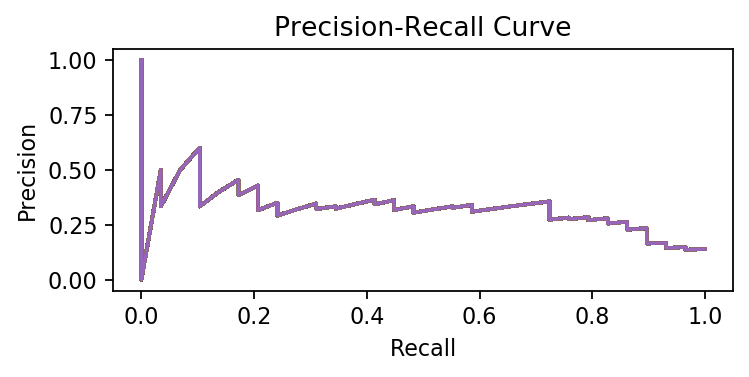

In [53]:
precision_recall = []
for prediction in preds_test_xgb:
    precision, recall, _ = precision_recall_curve(labels, preds_test_xgb)
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None, figsize=(5, 2), dpi=160, facecolor='w', edgecolor='k')
plt.plot(*precision_recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()